In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
import ccdproc
import glob
import tqdm

%matplotlib inline

In [3]:
datafolder = '../data/apr10/red/'
biasfiles = glob.glob(datafolder + 'bias/nr_23.54.37_001.fits')
flatfiles = glob.glob(datafolder + 'flat/nr_23.24.56_004.fits')
sciencefiles = glob.glob(datafolder + 'science/*')[4:] # the first few files suck


In [4]:
gain = 0.78 * u.electron / u.adu
readnoise = 4.5 * u.electron 

imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

In [5]:
f = fits.open(biasfiles[0])[0]

bias_list = [ccdproc.CCDData(data=f.data[i], meta=f.header, unit='adu') for i in range(12)]
master_bias = ccdproc.combine(bias_list, method='median')


bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(master_bias))

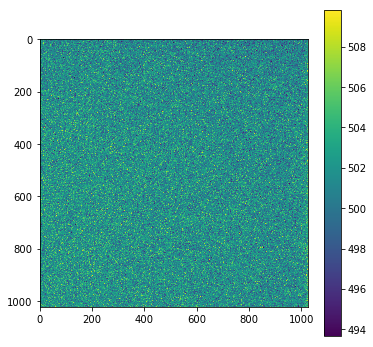

In [6]:
plt.figure(figsize=(6, 6))
plt.imshow(master_bias, vmax=bias_mean + 4*bias_std, vmin=bias_mean - 4*bias_std)
plt.colorbar()

In [7]:
flat_list = []
for flatfile in flatfiles:
    f = fits.open(flatfile)[0]
    n = f.data.shape[0]
    for x in [ccdproc.CCDData(data=f.data[i], meta=f.header, unit='adu') for i in range(n)]:
        flat_list.append(x)


In [8]:
for i in range(len(flat_list)):
    flat_list[i] = ccdproc.subtract_bias(flat_list[i], master_bias)

In [9]:
master_flat = ccdproc.combine(flat_list, method='median', scale=lambda x: 1./np.median(x))

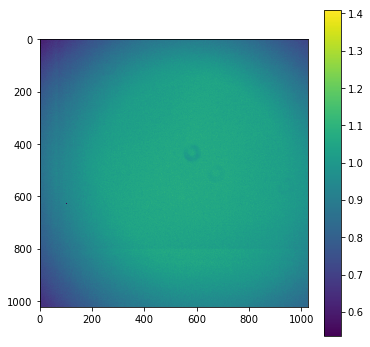

In [10]:
f_min, f_max, f_mean, f_std = imstats(np.asarray(master_flat))
plt.figure(figsize=(6, 6))
plt.imshow(master_flat, vmin=f_mean-5*f_std, vmax=f_mean+5*f_std)
plt.colorbar()

In [11]:
science_list = []
for sciencefile in sciencefiles:
    f = fits.open(sciencefile)[0]
    n = f.data.shape[0]
    for x in [ccdproc.CCDData(data=f.data[i], meta=f.header, unit='adu') for i in range(n)]:
        science_list.append(x) 

In [12]:
for i in range(len(science_list)):
    science_list[i] = ccdproc.subtract_bias(science_list[i], master_bias)

In [13]:
for i in range(len(science_list)):
    science_list[i] = ccdproc.flat_correct(science_list[i], master_flat)

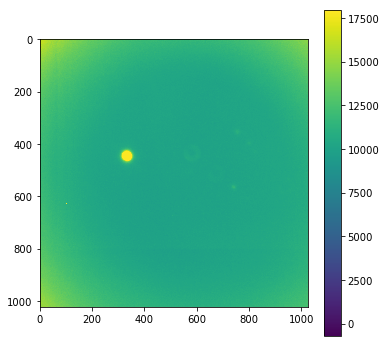

In [14]:
f_min, f_max, f_mean, f_std = imstats(science_list[4].data)

plt.figure(figsize=(6, 6))
plt.imshow(science_list[4],vmin=f_mean-5*f_std, vmax=f_mean+3*f_std)
plt.colorbar()

In [15]:
from photutils import DAOStarFinder
from astropy.stats import mad_std

In [16]:
image = science_list[50].data

In [17]:
bkg_sigma = mad_std(image)    

In [18]:
daofind = DAOStarFinder(fwhm=4., threshold=3.*bkg_sigma)

In [19]:
sources = daofind(image)

In [20]:
np.min(sources['mag'])

-4.6999830367920428

In [21]:
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
positions = (sources['xcentroid'], sources['ycentroid'])  
apertures = CircularAperture(positions, r=4.)    
phot_table = aperture_photometry(image, apertures) 
print(phot_table)  

 id      xcenter            ycenter        aperture_sum
           pix                pix                      
--- ------------------ ------------------ -------------
  1  1.509949074266075 1.5483600195729275 534607.769351
  2 1021.4623735973062 1.5525360065768616 470302.287923
  3  332.1752764188052  450.2004858740403 9797189.70242
  4 100.35257349601542  626.7026963763226 1287252.80709
  5 1.5153496481683675 1021.4437891079681 490470.077678
  6 1021.4503117607655 1021.4554750282578 400137.866356


/Users/tom/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


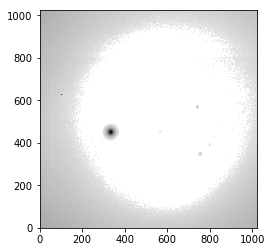

In [22]:
plt.imshow((image - np.median(image))**0.3, cmap='gray_r', origin='lower')
# apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [55]:
a = np.array([])
b = np.array([])
c = np.array([])
bg = np.array([])
image = science_list[100].data
bkg_sigma = mad_std(image)
daofind = DAOStarFinder(fwhm=6., threshold=5.*bkg_sigma)
sources = daofind(image)
idx = np.argmax(sources['flux'])
positions = (sources['xcentroid'], sources['ycentroid'])
a1 = CircularAperture(positions, r=4)
a2 = CircularAperture(positions, r=6)
a3 = CircularAperture(positions, r=8)
annulus_apertures = CircularAnnulus(positions, r_in=550., r_out=555)  
apers = [a1, a2, a3, annulus_apertures]
for d in tqdm.tqdm(range(len(science_list[:]))):
    image = science_list[d].data
    phot_table = aperture_photometry(image, apers)
    a = np.r_[a,phot_table[3]['aperture_sum_0']]
    b = np.r_[b, phot_table[3]['aperture_sum_1']]
    c = np.r_[c, phot_table[3]['aperture_sum_2']]
    bg = np.r_[bg, phot_table[3]['aperture_sum_3']]

100%|██████████| 230/230 [00:58<00:00,  4.69it/s]


In [33]:
sources['id' == 3]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,2.11024034883,2.16479324759,0.400137505655,0.141265650659,0.0101270537131,49.0,0.0,16620.3175598,7.95991769599,-2.2522714431


id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,2.1102403488329005,2.164793247587518,696543.180313,1171691.21989,1749313.66401,3461161.57551
2,1020.8614268716634,2.152027726452039,583097.726014,982016.415288,1467811.34221,2943613.68189
3,332.25159722825583,454.556143269509,3863182.77485,9832890.51997,19118937.0054,10183739.5605
4,100.27595123435722,626.7143686720196,1310492.87604,2031678.97157,3043272.98577,8158198.52739
5,2.129949303466059,1020.8228567674911,609428.922032,1027065.08875,1537160.33825,3125904.86102
6,1020.8510897415757,1020.838300289258,479339.12429,808816.222079,1209726.37982,2456642.66422


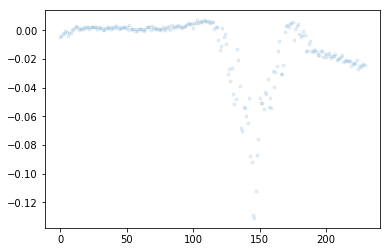

In [34]:
plt.plot((a/bg) / np.median(a/bg) - 1.0, '.', alpha=0.1)
# plt.plot((b-bg) / np.median(b-bg) - 1.0, '.', alpha=0.1)
# plt.plot((c-bg) / np.median(c-bg) - 1.0, '.', alpha=0.1)
# plt.plot((bg) / np.median(bg) - 1.0, '.')
phot_table

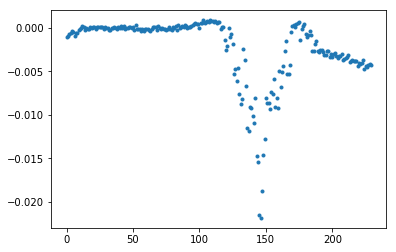

In [46]:
plt.plot((a/bg) -np.mean(a[40:100]/bg[40:100]), '.')

In [36]:
print(np.mean(a[40:100]) / np.std(a[40:100]))
print(np.mean(b[40:100]) / np.std(b[40:100]))
print(np.mean(c[40:100]) / np.std(c[40:100]))
print(np.mean(bg[40:100]) / np.std(bg[40:100]))

870.702255337
770.630372283
690.907712382
541.723091462


In [37]:
# plt.figure(figsize=(16, 16))
# plt.imshow(science_list[200][440:490,315:345])

In [38]:
# plt.figure(figsize=(6, 6))

# plt.imshow((((medim)- np.median(medim)) / np.median(medim)), vmax)
# plt.colorbar()

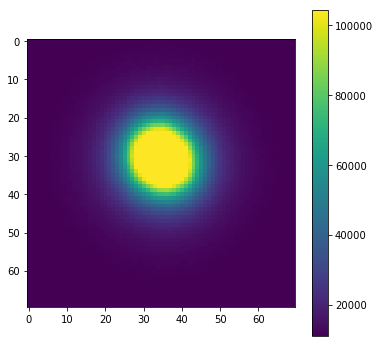

In [39]:
f_min, f_max, f_mean, f_std = imstats(science_list[4].data)

plt.figure(figsize=(6, 6))
plt.imshow(science_list[4][450-35:450+35,332-35:332+35],vmin=f_mean-0*f_std, vmax=f_mean+40*f_std)
plt.colorbar()

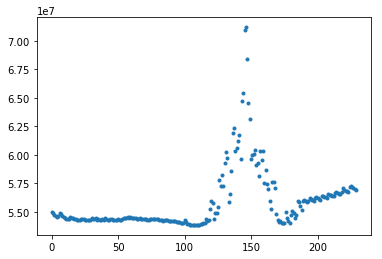

In [54]:
plt.plot(bg, '.')